In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import sys
import numpy as np
import imageio
import os
import matplotlib.pyplot as plt
import tensorflow as tf
import keras 
import cv2
from sklearn.utils import shuffle


In [0]:
import random
random.seed(2) # Python
np.random.seed(1) #numpy
from tensorflow import set_random_seed
set_random_seed(3) # Tensorflow

In [0]:


#The path to the  data
root_path = "./drive/My Drive/DataSet150"
train_path = os.path.join(root_path,'Traning') 
validation_path = os.path.join(root_path,'Evalution')

def load_image(path, n = 0):
    X = []
    
    #Load every alphabet seperately and place that in one tensor
    for alphabet in os.listdir(path):
#         print("Loading Alphabet: " + alphabet)
        alphabet_path = os.path.join(path, alphabet)
       
        category_images = []
            
        if not os.path.isdir(alphabet_path):
                continue
            
            #Read evey image with in the directory
        for filename in os.listdir(alphabet_path):
                image_path = os.path.join(alphabet_path, filename)
                image = imageio.imread(image_path)
                width = 150
                height = 150 # keep original height
                dim = (height,width)
 
                # resize image
                image = cv2.resize(image, dim)
                image=cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
                image= np.expand_dims(image, axis=0)
#                 print(image_path)
                #Image preprocessing
                image = image/255
                image = 1 - image
                
                X.append(image)
                
        
    X = np.stack(X)
    return X

In [0]:
print("Loading Training Set")
Xtrain = load_image(train_path)
print(Xtrain.shape)


Loading Training Set
(801, 1, 150, 150)


In [0]:
print("Now loading evaluation set")
Xval = load_image(validation_path)
print(Xval.shape)

Now loading evaluation set
(764, 1, 150, 150)


In [0]:
def get_batch(data, batch_size):
    n_classes, n_examples, h, w = data.shape
    
    pairs = [np.zeros((batch_size, 1, h, w)) for i in range(2)]
    
    targets = np.zeros((batch_size,))
    targets[batch_size//2:] = 1
    
    categories = np.random.choice(n_classes, size = (batch_size), replace = False)
    
    for i in range(batch_size):
        category = categories[i]
        
        idx1 = np.random.randint(0, n_examples)
        pairs[0][i,:,:,:] = data[category, idx1].reshape(1, h,w)
        idx2 = np.random.randint(0, n_examples)
        
        if targets[i] == 0:
            category_2 = category
        else:
            category_2 = (category + np.random.randint(1, n_classes)) % n_classes
 
        
        pairs[1][i,:,:,:] = data[category_2, idx2].reshape(1, h, w)
        
    return pairs, targets

In [0]:
def generate(data,batch_size):
        """a generator for batches, so model.fit_generator can be used. """
        while True:
            pairs, targets = get_batch(Xtrain,batch_size)
            yield (pairs, targets)

In [0]:
def make_oneshot_task(N,data,language=None):
        """Create pairs of test image, support set for testing N way one-shot learning. """
        n_classes, n_examples, w, h = data.shape
        indices = np.random.randint(0,n_examples,size=(N,))
        categories = np.random.choice(range(n_classes),size=(N,),replace=False)            
        true_category = categories[0]
        ex1 = np.random.randint(0, n_examples)
        ex2 = np.random.randint(0, n_examples)
        # ex1, ex2 = np.random.choice(n_examples,replace=False,size=(0,))
        test_image = np.asarray([data[true_category,ex1,:,:]]*N).reshape(N, 1, w,h)
        support_set = data[categories,indices,:,:]
        support_set[0,:,:] = data[true_category,ex2]
        support_set = support_set.reshape(N, 1, w,h)
        targets = np.zeros((N,))
        targets[0] = 1
        targets, test_image, support_set = shuffle(targets, test_image, support_set)
        pairs = [test_image,support_set]

        return pairs, targets

In [0]:
def test_oneshot(model,N,k,data,verbose=0):
        """Test average N way oneshot learning accuracy of a siamese neural net over k one-shot tasks"""
        n_correct = 0
        if verbose:
            print("Evaluating model on {} random {} way one-shot learning tasks ...".format(k,N))
        for i in range(k):
            inputs, targets = make_oneshot_task(N,data)
            probs = model.predict(inputs)
            if np.argmax(probs) == np.argmax(targets):
                n_correct+=1
        percent_correct = (100.0*n_correct / k)
        if verbose:
            print("Got an average of {}% {} way one-shot learning accuracy".format(percent_correct,N))
        return percent_correct

In [0]:
def train(model, epochs, verbosity):
        model.fit_generator(self.generate(batch_size),)

In [0]:

from keras.models import Model, load_model
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dropout, Dense, Input, Lambda
from keras.layers.core import Lambda, RepeatVector, Reshape
from keras.layers.merge import concatenate
from keras.optimizers import Adam
from keras.regularizers import l2
from keras import backend as K
from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Lambda, RepeatVector, Reshape
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras import backend as K

In [0]:
#Contrastive Loss
def euclid_dist(input_pair):
    x, y = input_pair
    distance = K.sqrt(K.maximum(K.sum(K.square(x - y), axis=-1, keepdims=True), K.epsilon()))
    return distance

def euclid_dist_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0],1)

def contrastive_loss(y_true, y_pred):
    margin = 1
    y_true = -1 * y_true + 1
    return K.mean((1-y_true) * K.square(y_pred) + y_true *  K.square(K.maximum(margin - y_pred, 0.0)))

def acc(y_true, y_pred):
    ones = K.ones_like(y_pred)
    return K.mean(K.equal(y_true, ones - K.clip(K.round(y_pred), 0, 1)), axis=1)


In [0]:
im_width  =150
im_height =150
im_chan   =1 

In [0]:

input_img =Input(( im_chan,im_height,im_width ), name='img')

# print(input_img)
# Down Block 1
c1 = Conv2D(32,(1,1), activation='relu', kernel_regularizer=l2(2e-4) )(input_img)
p1 = MaxPooling2D(data_format="channels_first") (c1)

#Down Block 2
c2 = Conv2D(128, (1, 1), activation='relu', kernel_regularizer=l2(2e-4)) (p1)
p2 = MaxPooling2D(data_format="channels_first") (c2)

#Down Block 3
c3 = Conv2D(128, (1, 1), activation='relu', kernel_regularizer=l2(2e-4)) (p2)
p3 = MaxPooling2D(data_format="channels_first") (c3)

#Down Block 4
c4 = Conv2D(256, (1, 1), activation='relu', kernel_regularizer=l2(2e-4)) (p3)
p4 = MaxPooling2D(data_format="channels_first") (c4)
# # print(p4)
flat = Flatten()(p4)
output = Dense(100, activation='sigmoid')(flat)

# Instantiate the Model
model = Model(input_img, output)

input1 = Input(shape = (1,150,150))
input2 = Input(shape = (1,150,150))

output1 = model(input1)
output2 = model(input2)


distance = Lambda(euclid_dist, output_shape=euclid_dist_shape)([output1, output2])

prediction = Dense(1, activation='sigmoid')(distance)
    
siamese = Model(inputs=[input1, input2], outputs=prediction)
    
optimizer = 'adam'
    
siamese.compile(loss=contrastive_loss, optimizer=optimizer, metrics=[acc])

siamese.summary()

Model: "model_26"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_28 (InputLayer)           (None, 1, 150, 150)  0                                            
__________________________________________________________________________________________________
input_29 (InputLayer)           (None, 1, 150, 150)  0                                            
__________________________________________________________________________________________________
model_25 (Model)                (None, 100)          2127524     input_28[0][0]                   
                                                                 input_29[0][0]                   
__________________________________________________________________________________________________
lambda_12 (Lambda)              (None, 1)            0           model_25[1][0]            

In [0]:
#Training loop
print("!")
evaluate_every = 1 # interval for evaluating on one-shot tasks
loss_every=50 # interval for printing loss (iterations)
batch_size = 32
n_iter = 30
N_way = 50 # how many classes for testing one-shot tasks>
n_val = 30 #how mahy one-shot tasks to validate on?
best = -1
weights_path = "weights"
print("training")
for i in range(1, n_iter):
    (inputs,targets)=get_batch(Xtrain,batch_size)
    loss=siamese.train_on_batch(inputs,targets)
    print(loss)
    if i % evaluate_every == 0:
        print("evaluating")
        val_acc = test_oneshot(siamese,N_way,n_val,Xval,verbose=True)
        if val_acc >= best:
            print("saving")
            siamese.save(weights_path)
            best=val_acc

    if i % loss_every == 0:
        print("iteration {}, training loss: {:.2f},".format(i,loss))

!
training
[0.31418765, 0.5]
evaluating
Evaluating model on 30 random 50 way one-shot learning tasks ...
Got an average of 100.0% 50 way one-shot learning accuracy
saving
[0.29304472, 1.0]
evaluating
Evaluating model on 30 random 50 way one-shot learning tasks ...
Got an average of 90.0% 50 way one-shot learning accuracy
[0.26938364, 1.0]
evaluating
Evaluating model on 30 random 50 way one-shot learning tasks ...
Got an average of 96.66666666666667% 50 way one-shot learning accuracy
[0.24972977, 1.0]
evaluating
Evaluating model on 30 random 50 way one-shot learning tasks ...
Got an average of 90.0% 50 way one-shot learning accuracy
[0.22977228, 1.0]
evaluating
Evaluating model on 30 random 50 way one-shot learning tasks ...
Got an average of 96.66666666666667% 50 way one-shot learning accuracy
[0.23263648, 1.0]
evaluating
Evaluating model on 30 random 50 way one-shot learning tasks ...
Got an average of 93.33333333333333% 50 way one-shot learning accuracy
[0.21278359, 0.96875]
evaluati

In [0]:
from keras.applications import VGG16
from keras import backend
# force channels-last ordering
backend.set_image_data_format('channels_first')
print(backend.image_data_format())
vgg = VGG16(weights="imagenet", include_top=False,
	input_tensor=Input(shape=(3, 150, 150)))

# output = vgg.layers[-1].output
# output = keras.layers.Flatten()(output)
# vgg_model = Model(vgg.input, output)

# vgg_model.trainable = False
# for layer in vgg_model.layers:
#     layer.trainable = False

channels_first


In [0]:

import pandas as pd
pd.set_option('max_colwidth', -1)
layers = [(layer, layer.name, layer.trainable) for layer in vgg_model.layers]
pd.DataFrame(layers, columns=['Layer Type', 'Layer Name', 'Layer Trainable']) 

,Layer Type,Layer Name,Layer Trainable
0,<keras.engine.input_layer.InputLayer object at 0x7f4e83582978>,input_13,False
1,<keras.layers.convolutional.Conv2D object at 0x7f4e835823c8>,block1_conv1,False
2,<keras.layers.convolutional.Conv2D object at 0x7f4e83195eb8>,block1_conv2,False
3,<keras.layers.pooling.MaxPooling2D object at 0x7f4e831975f8>,block1_pool,False
4,<keras.layers.convolutional.Conv2D object at 0x7f4e83198a20>,block2_conv1,False
5,<keras.layers.convolutional.Conv2D object at 0x7f4e831a0198>,block2_conv2,False
6,<keras.layers.pooling.MaxPooling2D object at 0x7f4e82bf93c8>,block2_pool,False
7,<keras.layers.convolutional.Conv2D object at 0x7f4e82c03f60>,block3_conv1,False
8,<keras.layers.convolutional.Conv2D object at 0x7f4e82c08b00>,block3_conv2,False
9,<keras.layers.convolutional.Conv2D object at 0x7f4e82c127f0>,block3_conv3,False


In [0]:
# import glob
# import numpy as np
# import matplotlib.pyplot as plt
# from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, array_to_img
# IMG_DIM = (150, 150)
# train_files = glob.glob('Traning/*')

# train_imgs = [img_to_array(load_img(img, target_size=IMG_DIM)) for img in train_files]
# train_imgs = np.array(train_imgs)
# train_imgs_scaled = train_imgs.astype('float32')

# bottleneck_feature_example = vgg.predict(train_imgs_scaled[0:1:2])
# print(bottleneck_feature_example.shape)
# plt.imshow(bottleneck_feature_example[0][:,:,0])

In [0]:
vgg.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_13 (InputLayer)        (None, 3, 150, 150)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 64, 150, 150)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 64, 150, 150)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 75, 75)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 75, 75)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, 75, 75)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 128, 37, 37)       0     

In [0]:

# output = vgg.layers[-1].output
# output = keras.layers.Flatten()(output)
# vgg_model = Model(vgg.input, output)

# vgg_model.trainable = False
# for layer in vgg_model.layers:
#     layer.trainable = False
    
# import pandas as pd
# pd.set_option('max_colwidth', -1)
# layers = [(layer, layer.name, layer.trainable) for layer in vgg_model.layers]
# pd.DataFrame(layers, columns=['Layer Type', 'Layer Name', 'Layer Trainable'])  

In [0]:
import os
import numpy as np
from keras.preprocessing.image import ImageDataGenerator

base_dir = './drive/My Drive/DataSet150'
train_dir = os.path.join(base_dir, 'Traning')
validation_dir = os.path.join(base_dir, 'Evalution')
test_dir = os.path.join(base_dir, 'Testing')
datagen = ImageDataGenerator(rescale=1./255)
batch_size = 10

def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count,512, 4, 4))
    labels = np.zeros(shape=(sample_count))
    generator = datagen.flow_from_directory(
    directory,
    target_size=(150, 150),
    batch_size=batch_size,
    class_mode='binary')
    i=0
    for inputs_batch, labels_batch in generator:
        features_batch = vgg.predict(inputs_batch)
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            break
    return features, labels
train_features, train_labels = extract_features(train_dir, 700)
validation_features, validation_labels = extract_features(validation_dir, 500)
test_features, test_labels = extract_features(test_dir, 500)

train_features = np.reshape(train_features, (700, 4*4* 512))
validation_features = np.reshape(validation_features, (500, 4*4* 512))
test_features = np.reshape(test_features, (500, 4*4* 512))


Found 801 images belonging to 22 classes.
Found 764 images belonging to 22 classes.
Found 764 images belonging to 22 classes.


In [0]:
from keras import models
from keras import layers
from keras import optimizers 
from keras.utils import to_categorical
import matplotlib.pyplot as plt
model = models.Sequential()
model.add(layers.Dense(256, activation='relu', input_dim=4 * 4 * 512))
model.add(layers.Dropout(0.1))
model.add(layers.Dense(22, activation='sigmoid'))
model.compile(loss='categorical_crossentropy',optimizer=optimizers.RMSprop(lr=2e-5, rho=0.9),
              metrics=['accuracy'])          
history = model.fit(train_features,to_categorical(train_labels),
epochs=30,
batch_size=10,
validation_data=(validation_features, to_categorical(validation_labels)))



Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.

Train on 700 samples, validate on 500 samples
Epoch 1/30
700/700 [==============================] - 3s 5ms/step - loss: 2.8768 - acc: 0.1657 - val_loss: 2.6365 - val_acc: 0.4260
Epoch 2/30
700/700 [==============================] - 3s 4ms/step - loss: 2.4246 - acc: 0.5771 - val_loss: 2.1346 - val_acc: 0.8200
Epoch 3/30
700/700 [==============================] - 3s 4ms/step - loss: 1.8890 - acc: 0.8071 - val_loss: 1.5649 - val_acc: 0.9160
Epoch 4/30
700/700 [==============================] - 3s 4ms/step - loss: 1.3714 - acc: 0.8843 - val_loss: 1.1024 - val_acc: 0.9220
Epoch 5/30
700/700 [==============================] - 3s 4ms/step - loss: 1.0054 - acc: 0.9029 - val_loss: 0.7868 - val_acc: 0.9500
Epoch 6/30
700/700 [==============================] - 3s 4ms/step - loss: 0.7383 - acc: 0.9286 - val_loss: 0.5778 - val_acc: 0.9600
Epoch 7/30
700/700 [=========================

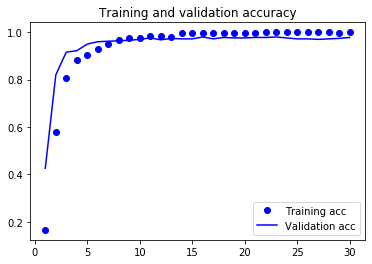

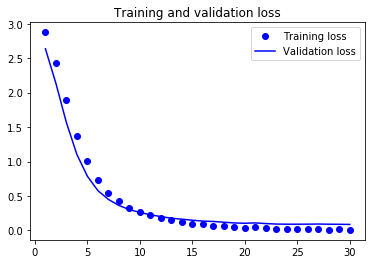

In [0]:
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [0]:
model.save('drive/My Drive/DataSet150/feature_extraction_basic2.h5')

In [0]:
from keras import models
from keras import layers
model = models.Sequential()
model.add(vgg)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(22, activation='sigmoid'))

In [0]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 512, 4, 4)         14714688  
_________________________________________________________________
flatten_8 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_14 (Dense)             (None, 256)               2097408   
_________________________________________________________________
dense_15 (Dense)             (None, 22)                5654      
Total params: 16,817,750
Trainable params: 2,103,062
Non-trainable params: 14,714,688
_________________________________________________________________


In [0]:

# print('This is the number of trainable weights '
# 'before freezing the conv base:', len(model.trainable_weights))
# #This is the number of trainable weights before freezing the conv base: 30
# conv_base.trainable = False
# print('This is the number of trainable weights '
# 'after freezing the conv base:', len(model.trainable_weights))
# #This is the number of trainable weights after freezing the conv base: 4

In [0]:
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers

train_datagen = ImageDataGenerator(
                rescale=1./255,
                rotation_range=40,
                width_shift_range=0.2,
                height_shift_range=0.2,
                shear_range=0.2,
                zoom_range=0.2,
                horizontal_flip=True,
                fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_directory(
                train_path,
                target_size=(150, 150),
                batch_size=10,
                class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
                validation_path,
                target_size=(150, 150),
                batch_size=10,
                class_mode='categorical')

model.compile(loss='categorical_crossentropy',
                optimizer=optimizers.RMSprop(lr=2e-5),
                metrics=['acc'])

history = model.fit_generator(
                train_generator,
                steps_per_epoch=100,
                epochs=10,
                validation_data=validation_generator,
                validation_steps=50)

Found 801 images belonging to 22 classes.
Found 764 images belonging to 22 classes.
Epoch 1/10
100/100 [==============================] - 425s 4s/step - loss: 3.0288 - acc: 0.0610 - val_loss: 2.9238 - val_acc: 0.1300
Epoch 2/10
100/100 [==============================] - 419s 4s/step - loss: 2.8508 - acc: 0.2370 - val_loss: 2.6847 - val_acc: 0.4534
Epoch 3/10
100/100 [==============================] - 424s 4s/step - loss: 2.5668 - acc: 0.5300 - val_loss: 2.3243 - val_acc: 0.7140
Epoch 4/10
100/100 [==============================] - 427s 4s/step - loss: 2.2022 - acc: 0.7181 - val_loss: 1.8685 - val_acc: 0.8644
Epoch 5/10
100/100 [==============================] - 421s 4s/step - loss: 1.7997 - acc: 0.8440 - val_loss: 1.4407 - val_acc: 0.9291
Epoch 6/10
100/100 [==============================] - 421s 4s/step - loss: 1.4324 - acc: 0.8920 - val_loss: 1.1204 - val_acc: 0.9320
Epoch 7/10
100/100 [==============================] - 419s 4s/step - loss: 1.1860 - acc: 0.8761 - val_loss: 0.8391 - v

In [0]:
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [0]:
conv_base.summary()


In [0]:
conv_base.trainable = True
set_trainable = False
for layer in conv_base.layers:
  if layer.name == 'block5_conv1':
    set_trainable = True
  if set_trainable:
    layer.trainable = True
  else:
    layer.trainable = False

In [0]:

model.compile(loss='categorical_crossentropy',
optimizer=optimizers.RMSprop(lr=2e-5),
metrics=['acc'])
history = model.fit_generator(
train_generator,
steps_per_epoch=100,
epochs=10,
validation_data=validation_generator,
validation_steps=50)

In [0]:
  import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()